In [1]:
%load_ext rpy2.ipython 

In [2]:
%%R 
w_max=5 # max wild-type plasmids
m_max=10 # max mutant plasmids

nt_init=matrix(0,nrow=w_max+1,ncol=m_max+1)
w_init=5
m_init=0
nt_init[w_init+1,m_init+1]=3.12e9
rownames(nt_init)=paste0('w',0:w_max)
colnames(nt_init)=paste0('m',0:m_max)

In [3]:
%%R 
cell_division_old <- function(nt){
  nt_div=matrix(0,nrow=w_max+1,ncol=m_max+1)
  rownames(nt_div)=paste0('w',0:w_max)
  colnames(nt_div)=paste0('m',0:m_max)
  for(a in 0:w_max){ # loop over the entire population
    for(b in 0:m_max){ 
      if((a+b)>=1){ # require a+b>0
        
        for(jpk in 0:(a+b)){ # loop over the total number of plasmids in first cell
          p_jpk=dbinom(jpk,a+b,0.5) # binomial distribution
          
          for(j in max(0,jpk-b):min(a,jpk)){
            new=p_jpk*dhyper(j,a,b,jpk)*nt[a+1,b+1]
            nt_div[j+1,jpk-j+1]=nt_div[j+1,jpk-j+1]+new # cell 1
            nt_div[a-j+1,b-(jpk-j)+1]=nt_div[a-j+1,b-(jpk-j)+1]+new # cell 2
          }
        }
      }
    }
  }
  return (nt_div)
}

cell_division <- function(nt){
  nt_div=nt*0
  for(a in 0:w_max){ # loop over the entire population
    for(b in 0:m_max){ 
      
      p_nt=dbinom(0:(a+b),a+b,0.5)*nt[a+1,b+1] # binomial distribution * number of cells
      for(jpk in 0:(a+b)){ # loop over the total number of plasmids in first cell
        j_all=max(0,jpk-b):min(a,jpk) # number of wild-type plasmids in first cell
        new_all=p_nt[jpk+1]*dhyper(j_all,a,b,jpk) # number of cells
        # row=j_all+1
        # column=jpk-j_all+1
        # element=(column-1)*(w_max+1)+(row)
        nt_div[(jpk-j_all)*(w_max+1)+j_all+1]=nt_div[(jpk-j_all)*(w_max+1)+j_all+1]+new_all # cell 1
        # row=a-j_all+1
        # column=b-(jpk-j_all)+1
        # element=(column-1)*(w_max+1)+(row)
        nt_div[(b-jpk+j_all)*(w_max+1)+a-j_all+1]=nt_div[(b-jpk+j_all)*(w_max+1)+a-j_all+1]+new_all # cell 1
      }
    }
  }
  return (nt_div)
}


In [4]:
%%R 
#u=0.01 # wt -> mutant rate
#r=2 # wt plasmid growth rate
#R=3 # mutant plasmid growth rate 

plasmid_replication_mutation_old <- function(nt_div,u,r,R){
    nt_growth=matrix(0,nrow=w_max+1,ncol=m_max+1)
    rownames(nt_growth)=paste0('w',0:w_max)
    colnames(nt_growth)=paste0('m',0:m_max)
    
    for(a in 0:w_max){ # loop over the entire population
      for(b in 0:m_max){ 
        a_plus1=floor(a*r)
        b_plus1=floor(b*R)
        
        new_wt=a_plus1-a
        w_to_m=0:new_wt
          
        a_plus2=a_plus1-w_to_m
        b_plus2=b_plus1+w_to_m
    
        a_plus2=ifelse (a_plus2<=w_max,a_plus2,w_max)

        for (i in 0:new_wt) {
          if(b_plus2[i+1]<=m_max)
              nt_growth[a_plus2[i+1]+1,b_plus2[i+1]+1]=
                  nt_growth[a_plus2[i+1]+1,b_plus2[i+1]+1] +
                  nt_div[a+1,b+1]*dbinom(i,new_wt,u)
        }
      }       
    }
    return (nt_growth)   
}

plasmid_replication_mutation <- function(nt_div,u,r,R){
  nt_growth=nt_div*0
  
  for(a in 0:w_max){ # loop over the entire population
    a_plus1=floor(a*r)
    new_wt=a_plus1-a
    w_to_m=0:new_wt
    a_plus2=a_plus1-w_to_m
    a_plus2=ifelse(a_plus2<=w_max,a_plus2,w_max) ##### this is not in the model
    
    p_w_to_m=dbinom(w_to_m,new_wt,u)
    
    for(b in 0:m_max){ 
      b_plus1=floor(b*R)
      b_plus2=b_plus1+w_to_m
      
      new=nt_div[a+1,b+1]*p_w_to_m
      for (i in w_to_m[b_plus2<=m_max]+1){
          nt_growth[a_plus2[i]+1,b_plus2[i]+1]=nt_growth[a_plus2[i]+1,b_plus2[i]+1]+new[i]
      }
      
    }       
  }
  return (nt_growth)   
}

In [5]:
%%R 
#S=0.8
#m_optimal=12 # NOTE: need m_optimal<m_max 
#m_lethal=15 # NOTE: need m_optimal<m_lethal<=m_max

cell_selection_old <-function(nt_growth, S, m_optimal, m_lethal){
    nt_selection=matrix(0,nrow=w_max+1,ncol=m_max+1)
    rownames(nt_selection)=paste0('w',0:w_max)
    colnames(nt_selection)=paste0('m',0:m_max)
    
    for(a in 0:w_max){ # loop over the entire population
      for(b in 0:m_max){
          if (b==0){
              nt_selection[a+1,b+1]=nt_growth[a+1,b+1]*S
          } else if (b<=m_optimal){
              nt_selection[a+1,b+1]=nt_growth[a+1,b+1]*(S+(1-S)*b/m_optimal)
          } else if (b<=m_lethal){
              nt_selection[a+1,b+1]=nt_growth[a+1,b+1]*((m_lethal-b)/(m_lethal-m_optimal))
          }
          if (b+a==0 | b>m_lethal){
              nt_selection[a+1,b+1] = 0
          }
      }
    }
    return (nt_selection)
}

cell_selection <-function(nt_growth, S, m_optimal, m_lethal){
  nt_selection=nt_growth*0
  
  nt_selection[,1]=nt_growth[,1]*S # b=0
  nt_selection[1,1]=0 # a+b=0
  nt_selection[,1:m_optimal+1]=t(t(nt_growth[,1:m_optimal+1])*(S+(1-S)*(1:m_optimal)/m_optimal))
  nt_selection[,(m_optimal+1):m_lethal+1]=t(t(nt_growth[,(m_optimal+1):m_lethal+1])*((m_lethal-(m_optimal+1):m_lethal)/(m_lethal-m_optimal)))
  if(m_lethal<m_max)
    nt_selection[,(m_lethal+1):m_max+1]=0  # b>m_lethal
  return (nt_selection)
}


In [6]:
%%R 
fcell_2_fplasmid_old <- function(nt_selection){
    wt_plasmid=0
    mutant_plasmid=0
    
    for(a in 0:w_max){ # loop over the entire population
      for(b in 0:m_max){
        wt_plasmid=wt_plasmid+nt_selection[a+1,b+1]*a
        mutant_plasmid=mutant_plasmid+nt_selection[a+1,b+1]*b
      }
    }
    
    return (mutant_plasmid/(wt_plasmid+mutant_plasmid))    
}

fcell_2_fplasmid <- function(nt_selection){
  
  wt_plasmid=sum(nt_selection*(0:w_max))
  mutant_plasmid=sum(t(nt_selection)*(0:m_max))
  
  return (mutant_plasmid/(wt_plasmid+mutant_plasmid))    
}

In [7]:
%%R 
generation=318
mutant_plasmid_freq=rep(-1,generation)
nt=nt_init

emperical_data=read.delim("F3_data1.tab", header=TRUE)
emperical_generations=emperical_data$generations

loss_old<-function(theta){
  u=theta[1]
  r=theta[2]
  R=theta[3]
  S=theta[4]
  m_optimal=round(theta[5]) # m_optimal needs to be integer!
  m_lethal=round(theta[6])  # m_lethal needs to be integer!
    
  if(u<0 | u>1 | r<1 | R<1 | r>=R | S<0 | S>1 | m_optimal<=0 | m_lethal<=m_optimal | m_lethal>m_max) {
    return (100000000)
  }
  
  for (i in 1:generation){
    nt_div=cell_division_old(nt)
    nt_growth=plasmid_replication_mutation_old(nt_div,u,r,R)
    nt_selection=cell_selection_old(nt_growth, S, m_optimal, m_lethal)
    mutant_plasmid_freq[i]=fcell_2_fplasmid_old(nt_selection)
    nt=nt_selection
  } 
  
  diff=mutant_plasmid_freq[emperical_generations]-emperical_data$frequency
  return (sum(diff^2))
  
} 

loss<-function(theta){
    u=theta[1]
    r=theta[2]
    R=theta[3]
    S=theta[4]
    m_optimal=round(theta[5]) # m_optimal needs to be integer!
    m_lethal=round(theta[6])  # m_lethal needs to be integer!
    
    if(u<=0 | u>=1 | r<1 | R<1 | r>=R | S<0 | S>1 | m_optimal<=0 | m_lethal<=m_optimal | m_lethal>m_max) {
        return(+Inf)
    }
    
    for (i in 1:generation){
        nt_div=cell_division(nt)
        nt_growth=plasmid_replication_mutation(nt_div,u,r,R)
        nt_selection=cell_selection(nt_growth, S, m_optimal, m_lethal)
        mutant_plasmid_freq[i]=fcell_2_fplasmid(nt_selection)
        nt=nt_selection
    } 

    diff=mutant_plasmid_freq[emperical_generations]-emperical_data$frequency
    return (sum(diff^2))
    
}

In [8]:
%%R 
theta0=c(0.00001, 1.2, 1.8, 0.8, 4, 6)
print (loss_old(theta0))
print (loss(theta0))

[1] 1.969933
[1] 1.969933


In [9]:
%%R 
# old code
ptm=proc.time()
res_old=optim(theta0,loss_old,control=c(maxit=1e6))
print(res_old)
proc.time()-ptm

$par
[1] 0.002607514 1.522980491 1.928765321 0.842194774 4.014060155 6.015436419

$value
[1] 0.0005933734

$counts
function gradient 
     175       NA 

$convergence
[1] 0

$message
NULL

   user  system elapsed 
813.875   4.123 835.591 


In [10]:
%%R
# new code
ptm=proc.time()
res=optim(theta0,loss,control=c(maxit=1e6))
print(res)
print(proc.time()-ptm)

identical(res_old,res)

$par
[1] 0.002607514 1.522980491 1.928765321 0.842194774 4.014060155 6.015436419

$value
[1] 0.0005933734

$counts
function gradient 
     175       NA 

$convergence
[1] 0

$message
NULL

   user  system elapsed 
363.167   1.315 366.651 
[1] FALSE


Plot the trajectory using the optimized parameters. 

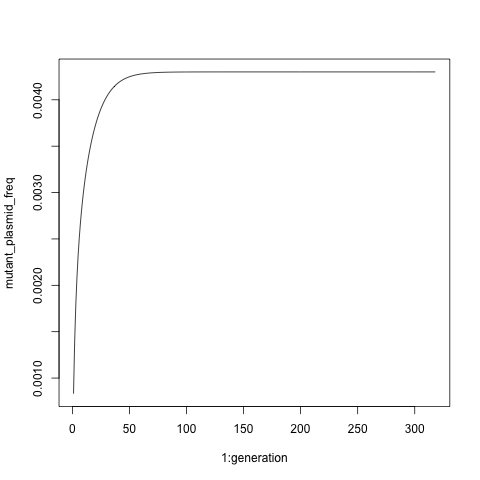

In [12]:
%%R 
theta_optimized=res$par
#theta_optimized=c(0.00001,1.60000,1.65000,0.20000,6.00000,8.00000)
mutant_plasmid_freq=rep(-1,generation)
trajectory = function (theta){
    u=theta[1]
    r=theta[2]
    R=theta[3]
    S=theta[4]
    m_optimal=round(theta[5]) # m_optimal needs to be integer!
    m_lethal=round(theta[6])  # m_lethal needs to be integer!
        
    for (i in 1:generation){
        nt_div=cell_division(nt)
        nt_growth=plasmid_replication_mutation(nt_div,u,r,R)
        nt_selection=cell_selection(nt_growth, S, m_optimal, m_lethal)
        mutant_plasmid_freq[i]=fcell_2_fplasmid(nt_selection)
        nt=nt_selection     
    } 
    plot (1:generation,mutant_plasmid_freq,type='l')
    #print (mutant_plasmid_freq)
}

trajectory(theta_optimized)